<a href="https://colab.research.google.com/github/Chang365/ESAA-25-1-assignments/blob/main/ESAA_25_1_0526_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 평균이동
## 평균이동의 개요
-  중심을 군집 중심으로 지속적으로 움직이면서 군집화 수행
- 중심을 데이터가 모여있는 밀도가 가장 높은 곳으로 이동
- 평균 이동 군집화는 데이터의 분포도를 이용해 군집 중심점을 찾음
- 군집 중심점은 데이터 포인트가 모여있는 곳이라는 생각에서 착안 -> 확률 밀도 함수 이용
- 확률 밀도 함수가 피크인 점을 군집 중심점으로 선정 -> 찾기 위해 KDE 사용
- 평균 이동 군집화: 확률 밀도가 가장 높은 곳으로 이동하기 위해 주변 데이터와의 거리 값을 KDE함수 값으로 입력한 뒤 그 반환 값을 현재위치에서 업데이트하면서 이동
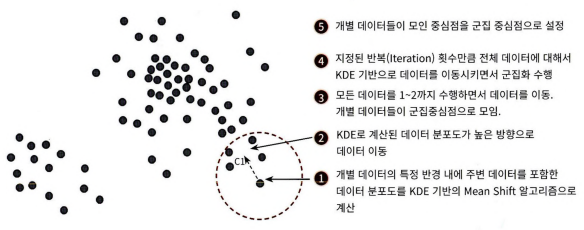



- KDE: 커널 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 방법
- 개별 관측 데이터에 커널 함수를 적용한 뒤 적용 값을 모두 더한 후 개별 관측 데이터의 건수로 나눠 확률 밀도 함수로 추정 (가우시안)
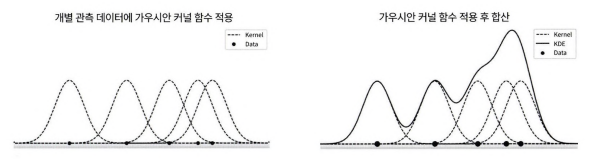

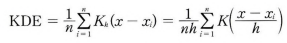

- 대역폭 H는 KDE 형태를 평활화하는데 적용
- 작은 h 값은 뾰족한 KDE -> 과적합
- 큰 h 값은 과도하게 평활 -> 과소적합
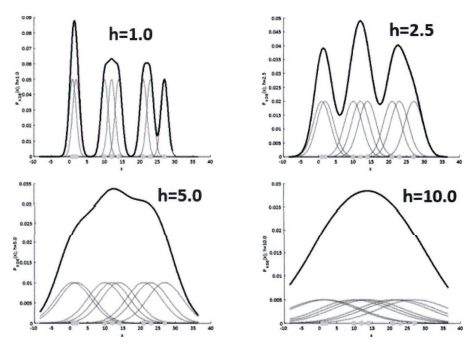

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift=MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


-> 군집이 6개로 분류 , 지나치게 세분화

In [2]:
# bandwidth를 살짝 높인 1.0으로 수행
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


-> 3개의 군집, 적절

In [3]:
#최적화된 bandwidth 찾기
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


In [4]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


<ipython-input-5-72d9a033201f>:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='' % label)


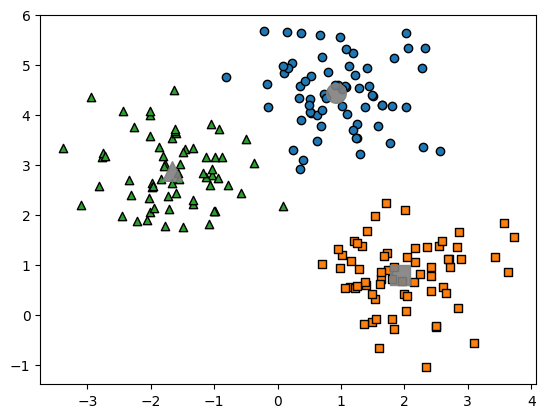

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    #군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='' % label)

plt.show()

In [6]:
# target 값과 군집 label 값 비교
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


- 평균 이동의 장점: 유연한 군집화, 이상치 작음, 미리 군집 개수 정할 필요 없음
- 단점: 오래걸림, bandwidth에 따라 군집화 영향도 큼


---

# 04 GMM (Gaussian Mixture Model)
## GMM(Gaussian Mixture Model) 소개
- 가우시안 분포(GaussianDistribution): 좌우 대칭형 종 형태를 가진 연속 확률 변수
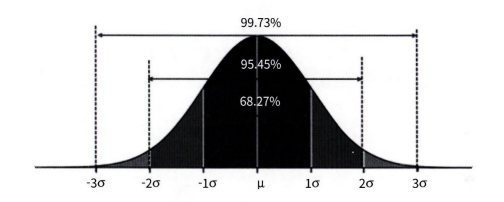


- GMM 군집화 방식: 서로 다른 정규 분포에 기반한 군집화를 수행하는 것
- 모수추정
  1. 개별 정규 분포의 평균과 분산
  2. 각 데이터가 어떤 정규 분포에 해당되는지의 확률
## GMM을 이용한 붓꽃 데이터 세트 군집화

In [7]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Modeling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [8]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmm_cluster' 칼럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target 값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


In [9]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


## GMM과 K-평균의 비교


In [12]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

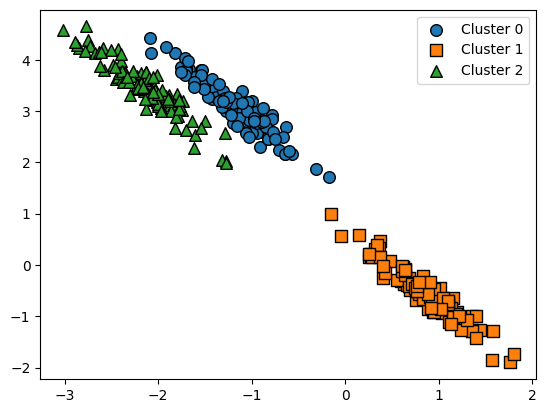

In [13]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std = 0.5를 만듦
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위헤 변환함.
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

<ipython-input-12-f4c266540d94>:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\


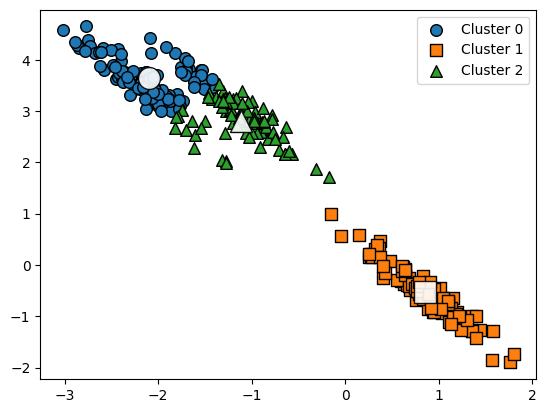

In [14]:
# 3개의 군집 기반 KMeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

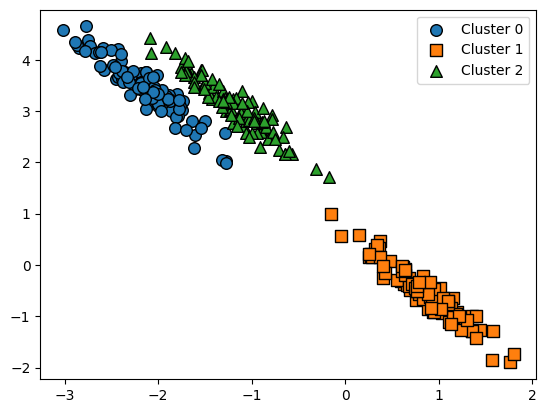

In [15]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정.
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

In [16]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64
